In [1]:
'''Main'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

'''Data Prep'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# Timer
import time as time

# handling class imbalance
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE , SMOTENC
from imblearn.combine import SMOTEENN

In [2]:
# Simulate Data, the same as that in Week 3
sample_size1= 10000

# number of rounds of simulations
sim_rounds = 100

# create random number generator object
rand = np.random.RandomState(888)

# simulating normal random variable, just initialize this object
df=pd.DataFrame(rand.normal(0,1, (sample_size1,5))) #you can replace normal by other distribution's name
# 0,1 are the mean and standard error
# 5 is the number of columns and 5000(sample_size1) is the number of rows

# just add the column name and also change V0 to e
df=df.add_prefix('X') 

# add the outcome variable Y, this is the true pattern of this predictive regression problem
def gen_Y(X0,X1,X2,X3,X4):
    Y=0.01*(X1/X2)-0.01*(X3/X4)+X0
    Y[Y<=np.percentile(Y,87)]=0 # the true pattern is only 1% Y=1
    Y[Y>=np.percentile(Y,88)]=0
    Y[Y>0]=1
    return Y

df['Y']=gen_Y(df.X0,df.X1,df.X2,df.X3,df.X4)

# preparing data for input and label
dataX = df.copy().drop(['Y'],axis=1)
dataY = df['Y'].copy()
dataY=dataY.astype(int)

df.describe() # the complete dataset

,X0,X1,X2,X3,X4,Y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.002120,0.008972,0.002554,0.001294,-0.005653,0.010000
std,0.995067,0.994135,1.016111,0.991412,1.004363,0.099504
min,-3.764940,-3.849600,-3.645351,-3.814431,-3.322366,0.000000
25%,-0.681879,-0.663965,-0.697125,-0.679107,-0.690493,0.000000
50%,-0.001382,0.004578,0.003886,0.009748,0.003102,0.000000
75%,0.657773,0.679866,0.692362,0.675042,0.672105,0.000000
max,3.557303,3.778570,3.982649,4.098996,4.399775,1.000000


In [3]:
# Now we use a nicer function to do classification
# This function includes K-fold cross validation
# This function output both predicted class and predicted prob.
# This function also generates all common performance metrics of classification
def build_model(data, features, target, classifier, oversample=None):
    '''
    Function that takes in data with features and target columns,
    builds a model using the specified classifier,
    and outputs the classification performance.
    
    Inputs:
        data (pd.DataFrame): Dataframe containing features and target columns for model building.
        features (list): List of features to use in model building.
        target (str): Name of target / label column.
        classifier (sklearn classifier Object): Model to build.
        
    Outputs:
        cm (pd.DataFrame): Confusion matrix.
        results (dict): Accuracy, Precision, Recall, F1 Score, AUC.
    '''
    
    # initialise stratified K Fold, 5 fold in this case
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    # get splitting iterations
    kf.get_n_splits(X=data[features], y=data[target])
    
    # lists to store results
    y_pred_all = []
    y_true_all = []
    y_proba_all = []
    
    # comprehensive dictionary of results
    results = dict()
    
    # generate indices to split data
    # for loop for K fold cross validation
    for train_index, test_index in kf.split(data[features], data[target]):
        ### train & test for current iteration ###
        curr_train, curr_test = data.iloc[train_index], data.iloc[test_index]
        # train set
        X_train = curr_train[features]
        y_train = curr_train[target]
        # test set
        X_test = curr_test[features]
        y_test = curr_test[target]
        
        ### handling class imbalance ###
        if oversample:
            X_train, y_train = oversample.fit_resample(X_train, y_train)
        
        # classifier
        clf = classifier
        # fit data
        clf.fit(X_train, y_train)
        # get predictions
        y_pred = clf.predict(X_test) # get predicted class
        y_proba = clf.predict_proba(X_test) # get predicted prob.
        # extend list
        y_pred_all.extend(y_pred)
        y_true_all.extend(y_test)
        y_proba_all.extend(y_proba[:, 1])
        
    # generate confusion matrix
    cm = pd.DataFrame(confusion_matrix(y_true=y_true_all, y_pred=y_pred_all), \
                      index=['Actual: 0', 'Actual: 1'], \
                      columns=['Pred: 0', 'Pred: 1'])

    # generate results
    report = classification_report(y_true=y_true_all, y_pred=y_pred_all, output_dict=True)
    results['accuracy'] = report['accuracy']
    results['recall'] = report['1']['recall']
    results['precision'] = report['1']['precision']
    results['f1'] = report['1']['f1-score']
    
    # auc
    fpr, tpr, thresholds = roc_curve(y_true=y_true_all, y_score=y_proba_all)
    auc_score = auc(fpr, tpr)
    results['auc'] = auc_score
    
    # average precision
    results['avg_precision'] = average_precision_score(y_true_all, y_pred_all)
    
    return cm, results

In [4]:
# define train data frame, list of features, and target column name
features = list(dataX.columns)
target = 'Y'
train = pd.concat([dataX, dataY], axis=1)

In [5]:
# We will try 3 simple algorithms first. XGBoost and LightGBM in the 2nd file.
# Classifier 1: KNN
start_time = time.time()
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
# build model
cm_knn, results_knn = build_model(train, features, target, clf)

print("Confusion Matrix: \n\n", cm_knn)
print("\n")
print(f"Precision Score: {results_knn['precision']}")
print(f"Recall Score: {results_knn['recall']}")
print(f"AUC: {results_knn['auc']}")
print(f"Avg. Precision: {results_knn['avg_precision']}")
print("--- %s seconds ---" % (time.time() - start_time))
# one important observation is that when k is greater than 4, 
# almost all are classified as 0.
# however, AUC keeps increasing, see the next block.
# this means AUC is a better metric than others

Confusion Matrix: 

            Pred: 0  Pred: 1
Actual: 0     9899        1
Actual: 1       99        1


Precision Score: 0.5
Recall Score: 0.01
AUC: 0.6642040404040405
Avg. Precision: 0.0149
--- 0.7625479698181152 seconds ---


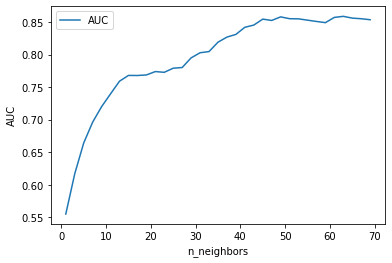

In [6]:
# Classifier 1: KNN with tuning
# I turn off warnings because those warnings are due to 0 in the confusion matrix
# so we cannot compute some metrics
import warnings
warnings.filterwarnings("ignore")

# KNN Results and AUC
validation_auc = [] # you need to clean the array if you restart
validation_apr = [] # you need to clean the array if you restart
neighbors_settings = range(1, 70, 2) # range of parameters to explore

for n_neighbors in neighbors_settings:
    
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    # build model
    cm_knn, results_knn = build_model(train, features, target, clf)
    
    # record validation set auc
    validation_auc.append(results_knn['auc'])
    validation_apr.append(results_knn['avg_precision'])
    
#print(validation_auc)
plt.plot(neighbors_settings, validation_auc, label="AUC")
plt.ylabel("AUC")
plt.xlabel("n_neighbors")
plt.legend()

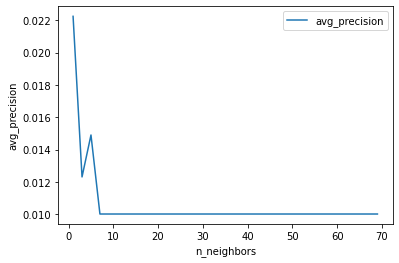

In [7]:
#print(validation_apr)
plt.plot(neighbors_settings, validation_apr, label="avg_precision")
plt.ylabel("avg_precision")
plt.xlabel("n_neighbors")
plt.legend()

In [8]:
# Classifier 2: NB (and no tuning)
start_time = time.time()
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
# build model
cm_nb, results_nb = build_model(train, features, target, gnb)

print("Confusion Matrix: \n\n", cm_nb)
print("\n")
print(f"Precision Score: {results_nb['precision']}")
print(f"Recall Score: {results_nb['recall']}")
print(f"AUC Score: {results_nb['auc']}")
print(f"Avg. Precision: {results_nb['avg_precision']}")
print("--- %s seconds ---" % (time.time() - start_time))
# Using NB for binary classification is very bad, 
# however, the AUC score is very good, even better than KNN
# This means the predicted probability is good, but the cutoff value by 50% is wrong

Confusion Matrix: 

            Pred: 0  Pred: 1
Actual: 0     9900        0
Actual: 1      100        0


Precision Score: 0.0
Recall Score: 0.0
AUC Score: 0.9384232323232322
Avg. Precision: 0.01
--- 0.20245862007141113 seconds ---


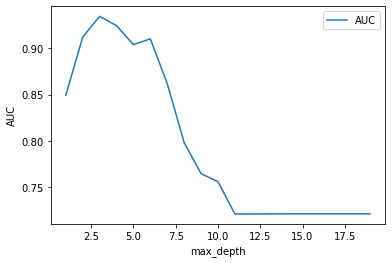

In [9]:
# Classifier 3: Decision Tree
# Again, same as several cases covered earlier this semester, 
# DT is quite resilient to imbalanced Y

from sklearn.tree import DecisionTreeClassifier

validation_auc = [] # you need to clean the array if you restart
validation_apr = []
max_depth = range(1, 20, 1) # the last argument is the step of increment,

for n_depth in max_depth:
    # initialise decision tree classifier
    dt = DecisionTreeClassifier(max_depth=n_depth,random_state=1)
    # build model
    cm_dt, results_dt = build_model(train, features, target, dt)
    # record validation set auc
    validation_auc.append(results_dt['auc'])
    validation_apr.append(results_dt['avg_precision'])
    
#print(validation_auc)
plt.plot(max_depth, validation_auc, label="AUC")
plt.ylabel("AUC")
plt.xlabel("max_depth")
plt.legend()

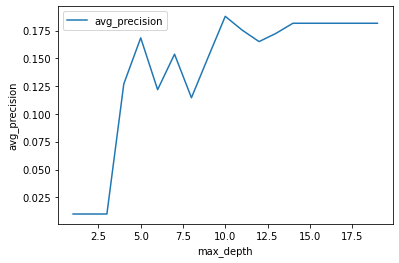

In [10]:
#print(validation_apr)
plt.plot(max_depth, validation_apr, label="avg_precision")
plt.ylabel("avg_precision")
plt.xlabel("max_depth")
plt.legend()

In [11]:
# Method 1: upweight. Just change the weight of rows with different labels in DT

# initialise decision tree classifier
dt = DecisionTreeClassifier(max_depth=3,class_weight={0:1, 1:40}, random_state=1)
# 0:1 means the weight for Y=0 is 1
# 1:40 means the weight for Y=1 is 40
# If you have more types, you may have 2:20, which means weight for Y=2 is 20

# build model
cm_dt_overweight, results_dt_overweight = build_model(train, features, target, dt)

print("Confusion Matrix: \n\n", cm_dt_overweight)
print("\n")
print(f"AUC Score: {results_dt_overweight['auc']}")
print(f"Avg. Precision: {results_dt_overweight['avg_precision']}")

Confusion Matrix: 

            Pred: 0  Pred: 1
Actual: 0     9664      236
Actual: 1       17       83


AUC Score: 0.9168803030303031
Avg. Precision: 0.2176561128526646


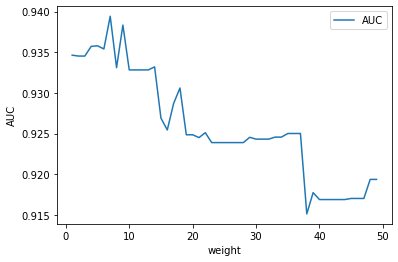

In [12]:
# Method 1 with tuning
validation_auc = [] # you need to clean the array if you restart
validation_apr = []
weight_range = range(1, 50, 1) # the last argument is the step of increment,

for w in weight_range:
    
    # initialise decision tree classifier
    dt = DecisionTreeClassifier(max_depth=3,class_weight={0:1, 1:w},random_state=1)
    # build model
    cm_dt_weight, results_dt_weight = build_model(train, features, target, dt)
    # record validation set auc
    validation_auc.append(results_dt_weight['auc'])
    validation_apr.append(results_dt_weight['avg_precision'])
    
#print(validation_auc)
plt.plot(weight_range, validation_auc, label="AUC")
plt.ylabel("AUC")
plt.xlabel("weight")
plt.legend()
# increasing weight seem to help a little bit, but increasing too much hurts

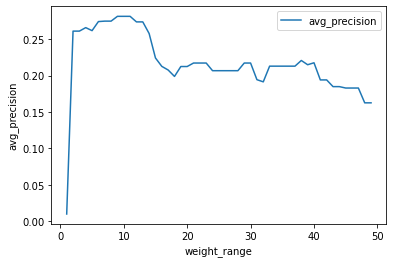

In [13]:
#print(validation_apr)
plt.plot(weight_range, validation_apr, label="avg_precision")
plt.ylabel("avg_precision")
plt.xlabel("weight_range")
plt.legend()

In [14]:
# Method 2: SMOTE only, no tuning
# define SMOTE strategy
start_time = time.time()

# the important one, we have two parameters, first is sampling ratio
# the second is the number of KNN
smote_only = SMOTE(sampling_strategy=0.02, k_neighbors=3, random_state=1)

# initialise decision tree classifier
dt = DecisionTreeClassifier(max_depth=3,random_state=1)

# build model
cm_dt_smote, results_dt_smote = build_model(train, features, target, dt, smote_only)

print("Confusion Matrix: \n\n", cm_dt_smote)
print("\n")
print(f"Precision Score: {results_dt_smote['precision']}")
print(f"Recall Score: {results_dt_smote['recall']}")
print(f"AUC Score: {results_dt_smote['auc']}")
print(f"Avg. Precision: {results_dt_smote['avg_precision']}")
print("--- %s seconds ---" % (time.time() - start_time))

Confusion Matrix: 

            Pred: 0  Pred: 1
Actual: 0     9822       78
Actual: 1       36       64


Precision Score: 0.4507042253521127
Recall Score: 0.64
AUC Score: 0.9461833333333333
Avg. Precision: 0.2920507042253521
--- 0.16655421257019043 seconds ---


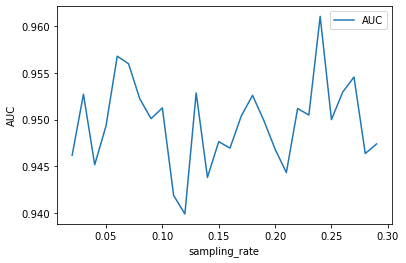

In [15]:
# SMOTE only with DT, tuning
# define SMOTE strategy

validation_auc = [] # you need to clean the array if you restart
validation_apr = []
sampling_range = np.arange(0.02, 0.3, 0.01) # the last argument is the step of increment,
# the starting point must be larger than the original ratio, which is 1%

for s in sampling_range:
    smote_only = SMOTE(sampling_strategy=s, k_neighbors=3, random_state=1)
    # initialise decision tree classifier
    dt = DecisionTreeClassifier(max_depth=3,random_state=1)
    # build model
    cm_dt_smote, results_dt_smote = build_model(train, features, target, dt, smote_only)
    # record validation set auc
    validation_auc.append(results_dt_smote['auc'])
    validation_apr.append(results_dt_smote['avg_precision'])
    
#print(validation_auc)
plt.plot(sampling_range, validation_auc, label="AUC")
plt.ylabel("AUC")
plt.xlabel("sampling_rate")
plt.legend()

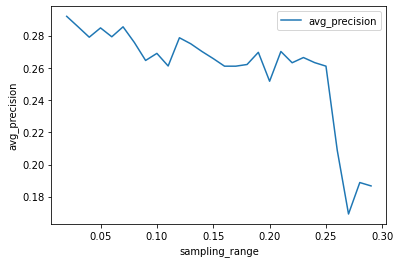

In [16]:
#print(validation_apr)
plt.plot(sampling_range, validation_apr, label="avg_precision")
plt.ylabel("avg_precision")
plt.xlabel("sampling_range")
plt.legend()

In [17]:
# Method 3: SMOTEENN strategy, this is slightly different from the other method
# this method is a combined approach, not just oversampling or only undersampling
enn_only = EditedNearestNeighbours(n_neighbors=5)
smote_enn = SMOTEENN(smote=smote_only , enn= enn_only)

# initialise decision tree classifier
dt = DecisionTreeClassifier(max_depth=3,random_state=1)

# build model
cm_dt_smoteENN, results_dt_smoteENN = build_model(train, features, target, dt, smote_enn)

print("Confusion Matrix: \n\n", cm_dt_smoteENN)
print("\n")
print(f"AUC Score: {results_dt_smoteENN['auc']}")
print(f"Avg. Precision: {results_dt_smoteENN['avg_precision']}")

Confusion Matrix: 

            Pred: 0  Pred: 1
Actual: 0     9241      659
Actual: 1       12       88


AUC Score: 0.955690909090909
Avg. Precision: 0.10486800535475234


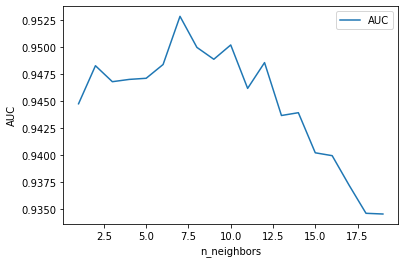

In [18]:
validation_auc = [] # you need to clean the array if you restart
validation_apr = []
neighbor_range = range(1, 20, 1) # the last argument is the step of increment,

for n in neighbor_range:
    smote_only = SMOTE(sampling_strategy=0.3, random_state=1)
    # define SMOTEENN strategy
    enn_only = EditedNearestNeighbours(n_neighbors=n)
    smote_enn = SMOTEENN(smote=smote_only , enn= enn_only)
    # initialise decision tree classifier
    dt = DecisionTreeClassifier(max_depth=3,random_state=1)
    # build model
    cm_dt_smoteenn, results_dt_smoteenn = build_model(train, features, target, dt, smote_enn)
    # record validation set auc
    validation_auc.append(results_dt_smoteenn['auc'])
    validation_apr.append(results_dt_smoteenn['avg_precision'])
    
#print(validation_auc)
plt.plot(neighbor_range, validation_auc, label="AUC")
plt.ylabel("AUC")
plt.xlabel("n_neighbors")
plt.legend()
# the benefit is unclear in this case

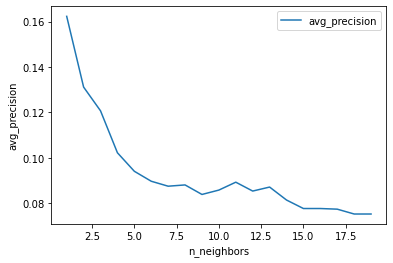

In [19]:
#print(validation_apr)
plt.plot(neighbor_range, validation_apr, label="avg_precision")
plt.ylabel("avg_precision")
plt.xlabel("n_neighbors")
plt.legend()